In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import os
import geopandas as gp
import yaml
import math

from scipy.spatial import ConvexHull
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon

from pykrige.ok import OrdinaryKriging
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pyproj import Proj
from scipy.io import savemat

In [2]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import plotlib

In [3]:
flag_project = 1 # 0--regular; 1--repartrition

In [4]:
if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']

#name_project = 'project/output_FJSJ_16-01/'               
#name_project = 'project_repartrition/repartrition_01-03/'               
#name_project = 'project_voronoi/voronoi_01-03/'         

In [5]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v4.0/output_repar_v9.5_01--10-16Hz/


In [6]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [7]:
dir_model_fund = dir_project + info_basic['rdir_model_fund']
dir_model = dir_project + info_basic['rdir_model']
dir_inv = dir_project + info_basic['rdir_inv_BFGS']
dir_image = dir_project + info_basic['rdir_image']+'Vs_compare/'
if not os.path.exists(dir_image):
    os.makedirs(dir_image)
dir_partition = dir_project + info_basic['rdir_partition']
key_subworks = info_basic['key_subworks']
M = len(key_subworks)
key_subworks

['1--08-03',
 '2--09-03',
 '3--10-03',
 '4--11-03',
 '5--12-03',
 '6--13-03',
 '7--14-03',
 '8--15-03',
 '9--16-03',
 '10--18-03',
 '12--20-03',
 '13--21-03',
 '15--23-03',
 '17--25-03',
 '18--26-03',
 '19--27-03',
 '20--28-03',
 '21--29-03',
 '22--30-03',
 '23--31-03',
 '28--36-03',
 '30--41-03',
 '31--42-03',
 '34--47-03',
 '35--48-03',
 '36--52-03',
 '37--53-03',
 '38--07-04',
 '39--08-04',
 '40--09-04',
 '41--10-04',
 '42--12-04',
 '43--13-04',
 '44--17-04',
 '45--20-04',
 '46--21-04',
 '48--23-04',
 '49--24-04',
 '50--25-04',
 '51--27-04',
 '52--28-04',
 '53--29-04',
 '54--30-04',
 '55--31-04',
 '56--32-04',
 '57--33-04',
 '58--34-04',
 '60--36-04',
 '63--47-04',
 '65--49-04',
 '67--53-04',
 '68--08-05',
 '69--12-05',
 '70--13-05',
 '71--14-05',
 '72--16-05',
 '75--22-05',
 '76--24-05',
 '77--26-05',
 '78--27-05',
 '79--28-05',
 '80--29-05',
 '81--30-05',
 '85--36-05',
 '86--37-05',
 '88--39-05',
 '89--40-05',
 '91--42-05',
 '93--44-05',
 '98--53-05',
 '99--54-05',
 '100--07-06',


In [8]:
dir_file = 'ModelValidCode/ModelValidCode/parameter_prepare/'

In [9]:
def GetStationPairs(nsta):
    StationPair = []
    for ii in range(nsta):
        for jj in range(ii+1,nsta):
            StationPair.append(ii)
            StationPair.append(jj)
    StationPair = np.array(StationPair,dtype=np.int32)
    return StationPair

In [10]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist() 
lat_stations_all =  stainfo['latitude'].tolist() 
lon_stations_all =  stainfo['longitude'].tolist() 
elevation_stations_all = stainfo['elevation'].tolist()

In [11]:
stations_partition = {}
lat_stations_partition = {}
lon_stations_partition = {}
lat_centroid_partition = []
lon_centroid_partition = []
num_stations = []
for key in key_subworks:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_partition[key] = stations_this
    lat_stations_partition[key] = lat_stations_this.astype(float)
    lon_stations_partition[key] = lon_stations_this.astype(float)
    num_stations.append(len(stations_this))
    lat_centroid_partition.append(np.mean(lat_stations_this.astype(float)))
    lon_centroid_partition.append(np.mean(lon_stations_this.astype(float)))

In [12]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

### Interpolate 3D structure

In [13]:
dz = 5
N = 50
num_x = 50
num_y = 50
type_interp = 'linear'
flag_save = 1 # 1--npz; 2--mat

In [14]:
# Read all data
struc = {}
struc_fund = {}
flag = 0
for key_subwork in key_subworks:
    file_model = dir_model + 'model_'+key_subwork+'.txt'
    file_model_fund = dir_model_fund + 'model_'+key_subwork+'.txt'
    model = np.loadtxt(file_model)
    model_fund = np.loadtxt(file_model_fund)
    struc[key_subwork] = {}
    struc[key_subwork]['layer'] = model[:, 0]
    struc[key_subwork]['z'] = model[:, 1]
    struc[key_subwork]['rho'] = model[:, 2]
    struc[key_subwork]['vs'] = model[:, 3]
    struc[key_subwork]['vp'] = model[:, 4]
    struc[key_subwork]['std'] = model[:, 5]
    struc_fund[key_subwork] = {}
    struc_fund[key_subwork]['layer'] = model_fund[:, 0]
    struc_fund[key_subwork]['z'] = model_fund[:, 1]
    struc_fund[key_subwork]['rho'] = model_fund[:, 2]
    struc_fund[key_subwork]['vs'] = model_fund[:, 3]
    struc_fund[key_subwork]['vp'] = model_fund[:, 4]
    struc_fund[key_subwork]['std'] = model_fund[:, 5]
    flag += 1
    print('Read structure model: %s (%d/%d)' % (key_subwork, flag, M))

vs_horizon = {}
vs_horizon_fund = {}
for i in range(N):
    vs_horizon[i] = []
    vs_horizon_fund[i] = []
    for key_subwork in key_subworks:
        vs_horizon[i].append(struc[key_subwork]['vs'][i])
        vs_horizon_fund[i].append(struc_fund[key_subwork]['vs'][i])

Read structure model: 1--08-03 (1/437)
Read structure model: 2--09-03 (2/437)
Read structure model: 3--10-03 (3/437)
Read structure model: 4--11-03 (4/437)
Read structure model: 5--12-03 (5/437)
Read structure model: 6--13-03 (6/437)
Read structure model: 7--14-03 (7/437)
Read structure model: 8--15-03 (8/437)
Read structure model: 9--16-03 (9/437)
Read structure model: 10--18-03 (10/437)
Read structure model: 12--20-03 (11/437)
Read structure model: 13--21-03 (12/437)
Read structure model: 15--23-03 (13/437)
Read structure model: 17--25-03 (14/437)
Read structure model: 18--26-03 (15/437)
Read structure model: 19--27-03 (16/437)
Read structure model: 20--28-03 (17/437)
Read structure model: 21--29-03 (18/437)
Read structure model: 22--30-03 (19/437)
Read structure model: 23--31-03 (20/437)
Read structure model: 28--36-03 (21/437)
Read structure model: 30--41-03 (22/437)
Read structure model: 31--42-03 (23/437)
Read structure model: 34--47-03 (24/437)
Read structure model: 35--48-03 (2

In [15]:
#points = np.column_stack((lon_stations_all, lat_stations_all))
points = np.column_stack((lon_centroid_partition, lat_centroid_partition))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
index_sta = []
lon_stations_in = []
lat_stations_in = []
stalist_in = []
elevation_stations_in = []
for i in range(len(lon_stations_all)):
    if polygon.contains(Point(lon_stations_all[i], lat_stations_all[i])):
        index_sta.append(i)
        stalist_in.append(stalist_all[i])
        lon_stations_in.append(lon_stations_all[i])
        lat_stations_in.append(lat_stations_all[i])
        elevation_stations_in.append(elevation_stations_all[i])

In [16]:
def compute_affine_transform(original_points, target_points):
    A_matrix = np.array([[original_points[0][0], original_points[0][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[0][0], original_points[0][1], 1],
                         [original_points[1][0], original_points[1][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[1][0], original_points[1][1], 1],
                         [original_points[2][0], original_points[2][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[2][0], original_points[2][1], 1]])

    A1_B1_C1 = np.array([target_points[0][0], target_points[0][1], target_points[1][0], target_points[1][1], target_points[2][0], target_points[2][1]])

    coefficients = np.linalg.solve(A_matrix, A1_B1_C1)

    affine_matrix = np.array([[coefficients[0], coefficients[1], coefficients[2]],
                               [coefficients[3], coefficients[4], coefficients[5]],
                               [0, 0, 1]])

    return affine_matrix

In [17]:
# Affine transformation
lon_stations_all_new = []
lat_stations_all_new = []
for sta in stalist_all:
    if int(sta[1:3]) <= 60:
        lon_stations_all_new.append(lon_stations_all[stalist_all.index(sta)])
        lat_stations_all_new.append(lat_stations_all[stalist_all.index(sta)])
refs = ['R0101','R6001','R6020']
lon_refs = [lon_stations_all[stalist_all.index(ref)] for ref in refs]
lat_refs = [lat_stations_all[stalist_all.index(ref)] for ref in refs]
loc_refs = np.column_stack([lon_refs,lat_refs])
loc_refs_new = np.array([[0,0],[600,0],[600,600]])

affine_matrix = compute_affine_transform(loc_refs, loc_refs_new)

In [18]:
# all stations
x_stations_all = []
y_stations_all = []
for i in range(len(lon_stations_all)):
    loc_sta = np.array([lon_stations_all[i],lat_stations_all[i],1])
    loc_sta_new = np.dot(affine_matrix,loc_sta)
    x_stations_all.append(loc_sta_new[0])
    y_stations_all.append(loc_sta_new[1])
np.savetxt(dir_project + 'stations_all_trans.txt', np.column_stack((stalist_all,x_stations_all, y_stations_all)), fmt='%s')
#with open('stations_all_trans.txt', 'w') as f:
#    for i in range(len(stalist_all)):
#        f.write('%s %f %f\n' % (stalist_all[i], x_stations_all[i], y_stations_all[i]))
# new stations
x_stations_all_new = []
y_stations_all_new = []
for i in range(len(lon_stations_all_new)):
    loc_sta = np.array([lon_stations_all_new[i],lat_stations_all_new[i],1])
    loc_sta_new = np.dot(affine_matrix,loc_sta)
    x_stations_all_new.append(loc_sta_new[0])
    y_stations_all_new.append(loc_sta_new[1])
# in stations
x_stations_in = []
y_stations_in = []
for i in range(len(lon_stations_in)):
    loc_sta = np.array([lon_stations_in[i],lat_stations_in[i],1])
    loc_sta_new = np.dot(affine_matrix,loc_sta)
    x_stations_in.append(loc_sta_new[0])
    y_stations_in.append(loc_sta_new[1])
np.savetxt(dir_project +'stations_in_trans.txt', np.column_stack((stalist_in,x_stations_in, y_stations_in)), fmt='%s')
# faults
x_faults = {}
y_faults = {}
faults_trans = {}   
for i in range(len(faults)):
    x_faults['clark'+str(i+1)] = []
    y_faults['clark'+str(i+1)] = []
    faults_trans['clark'+str(i+1)] = {}
    for j in range(len(faults['clark'+str(i+1)]['lon'])):
        loc_fault = np.array([faults['clark'+str(i+1)]['lon'][j],faults['clark'+str(i+1)]['lat'][j],1])
        loc_fault_new = np.dot(affine_matrix,loc_fault)
        x_faults['clark'+str(i+1)].append(loc_fault_new[0])
        y_faults['clark'+str(i+1)].append(loc_fault_new[1])
        faults_trans['clark'+str(i+1)]['x'] = x_faults['clark'+str(i+1)]
        faults_trans['clark'+str(i+1)]['y'] = y_faults['clark'+str(i+1)]
np.save(dir_project +'clark_faults_trans.npy', faults_trans)
# partitions
x_centroid_partition = []
y_centroid_partition = []
for i in range(len(lon_centroid_partition)):
    loc_centroid = np.array([lon_centroid_partition[i],lat_centroid_partition[i],1])
    loc_centroid_new = np.dot(affine_matrix,loc_centroid)
    x_centroid_partition.append(loc_centroid_new[0])
    y_centroid_partition.append(loc_centroid_new[1])
np.savetxt(dir_project + 'partition_trans.txt', np.column_stack((key_subworks,x_centroid_partition, y_centroid_partition)), fmt='%s')

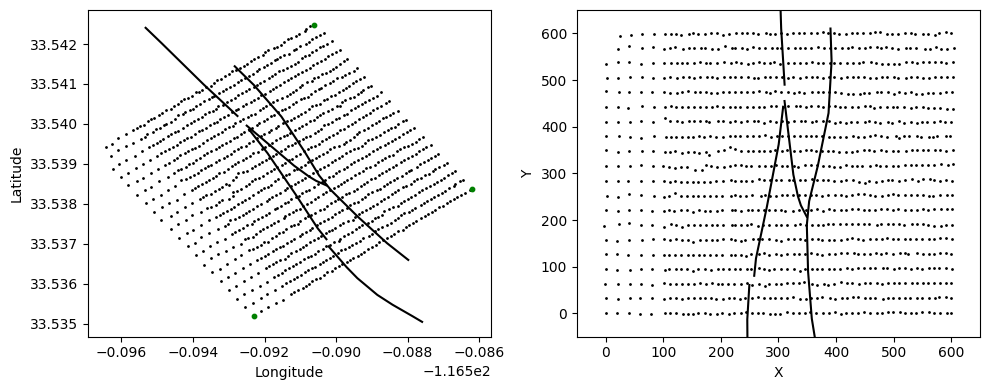

In [19]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax.scatter(lon_stations_all_new, lat_stations_all_new, c='k', label='Original',s = 1)
for ref in refs:
    ax.scatter(lon_stations_all[stalist_all.index(ref)], lat_stations_all[stalist_all.index(ref)], c='g', label='Original',s = 10)
for i in range(len(faults)):
    ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax = fig.add_subplot(122)
ax.scatter(x_stations_all_new, y_stations_all_new, c='k', label='Original',s = 1)
for i in range(len(faults)):
    ax.plot(x_faults['clark'+str(i+1)], y_faults['clark'+str(i+1)], 'k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-50,650)
ax.set_ylim(-50,650)
plt.tight_layout()

In [20]:
# generate grid
xx = np.linspace(np.min(x_centroid_partition), np.max(y_centroid_partition), num_x)
yy = np.linspace(np.min(y_centroid_partition), np.max(y_centroid_partition), num_y)
A,B = np.meshgrid(xx, yy)
X_star = np.hstack((A.flatten()[:,None], B.flatten()[:,None]))
x_grid = X_star[:,0]
y_grid = X_star[:,1]

In [21]:
vs_inter_fund = np.zeros([len(xx),len(yy),N])
vs_inter = np.zeros([len(xx),len(yy),N])
for i in range(N):
    print('Interpolating horizon %d/%d' % (i+1,N))
    OK = OrdinaryKriging(x_centroid_partition, y_centroid_partition, vs_horizon[i], variogram_model=type_interp,nlags=3)
    zz,ss = OK.execute('grid', xx, yy)
    vs_inter[:,:,i] = zz
    OK = OrdinaryKriging(x_centroid_partition, y_centroid_partition, vs_horizon_fund[i], variogram_model=type_interp,nlags=3)
    zz,ss = OK.execute('grid', xx, yy)
    vs_inter_fund[:,:,i] = zz

Interpolating horizon 1/50
Interpolating horizon 2/50
Interpolating horizon 3/50
Interpolating horizon 4/50
Interpolating horizon 5/50
Interpolating horizon 6/50
Interpolating horizon 7/50
Interpolating horizon 8/50
Interpolating horizon 9/50
Interpolating horizon 10/50
Interpolating horizon 11/50
Interpolating horizon 12/50
Interpolating horizon 13/50
Interpolating horizon 14/50
Interpolating horizon 15/50
Interpolating horizon 16/50
Interpolating horizon 17/50
Interpolating horizon 18/50
Interpolating horizon 19/50
Interpolating horizon 20/50
Interpolating horizon 21/50
Interpolating horizon 22/50
Interpolating horizon 23/50
Interpolating horizon 24/50
Interpolating horizon 25/50
Interpolating horizon 26/50
Interpolating horizon 27/50
Interpolating horizon 28/50
Interpolating horizon 29/50
Interpolating horizon 30/50
Interpolating horizon 31/50
Interpolating horizon 32/50
Interpolating horizon 33/50
Interpolating horizon 34/50
Interpolating horizon 35/50
Interpolating horizon 36/50
I

In [22]:
def cartesian_to_geographic_2d(x, y):
    # 定义一个适当的投影，根据你的数据选择合适的投影方式
    # 这里假设使用 WGS 84 椭球体投影
    proj = Proj(proj='utm', zone=10, ellps='WGS84')
    
    # 将笛卡尔坐标系转换为经纬度,单位为米
    lon, lat = proj(x, y, inverse=True)
    
    return lon, lat

In [23]:
# save as npz
z = np.arange(0,N*dz,dz)
print('Save as mat')
lons = np.zeros_like(xx)
lats = np.zeros_like(yy)
for i in range(len(xx)):
    lon, lat = cartesian_to_geographic_2d(xx[i], yy[i])
    lons[i] = lon
    lats[i] = lat
lon_stations = np.zeros_like(x_stations_in)
lat_stations = np.zeros_like(y_stations_in)
for i in range(len(x_stations_in)):
    lon, lat = cartesian_to_geographic_2d(x_stations_in[i], y_stations_in[i])
    lon_stations[i] = lon
    lat_stations[i] = lat
filename = dir_file + 'Vs_inter.mat'
savemat(filename, {'vs_inter': vs_inter, 'x': xx-np.min(xx), 'y': yy-np.min(yy), 'z': z, 'lon_sta': lons, 'lat_sta': lats})
filename_fund = dir_file + 'Vs_inter_fund.mat'
savemat(filename_fund, {'vs_inter_fund': vs_inter_fund, 'x': xx-np.min(xx), 'y': yy-np.min(yy), 'z': z, 'lon_sta': lons, 'lat_sta': lats})

Save as mat


In [24]:
# save station in
lon_stations_in_new = np.zeros_like(x_stations_in)
lat_stations_in_new = np.zeros_like(y_stations_in)
for i in range(len(x_stations_in)):
    lon, lat = cartesian_to_geographic_2d(x_stations_in[i], y_stations_in[i])
    lon_stations_in_new[i] = lon
    lat_stations_in_new[i] = lat
filename = dir_file + 'sta_in.mat'
savemat(filename, {'lon_sta': lon_stations_in_new, 'lat_sta': lat_stations_in_new})
np.savetxt(dir_file+'stations_in.txt',np.array([stalist_in,stalist_in,lon_stations_in_new,lat_stations_in_new]).T,fmt='%s',delimiter=' ')

In [25]:
R_index = np.arange(5,19,2)
C_index = np.arange(12,54,5)
indexes = []
for row in R_index:
    for col in C_index:
        name = 'R'+str(col).zfill(2)+str(row).zfill(2)
        indexes.append(stalist_all.index(name))
stalist_in = np.array(stalist_all)[indexes]
lon_stations_virsrc = np.zeros_like(np.array(stalist_all)[indexes], dtype=float)
lat_stations_virsrc = np.zeros_like(np.array(stalist_all)[indexes], dtype=float)
for i in range(len(np.array(stalist_all)[indexes])):
    lon, lat = cartesian_to_geographic_2d(x_stations_all[indexes[i]], y_stations_all[indexes[i]])
    lon_stations_virsrc[i] = lon
    lat_stations_virsrc[i] = lat
filename = dir_file + 'sta_virsrc.mat'
savemat(filename, {'lon_sta': lon_stations_virsrc, 'lat_sta': lat_stations_virsrc})
np.savetxt(dir_file+'stations_virsrc.txt',np.array([stalist_in,stalist_in,lon_stations_virsrc,lat_stations_virsrc]).T,fmt='%s',delimiter=' ')


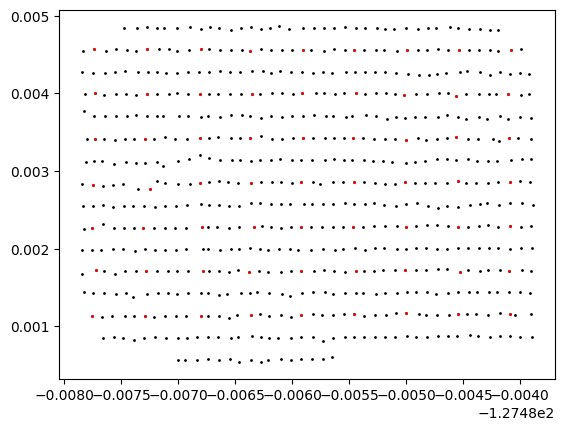

In [26]:
plt.scatter(lon_stations_in_new, lat_stations_in_new, c='k', label='Original',s = 1)
plt.scatter(lon_stations_virsrc, lat_stations_virsrc, c='r', label='Original',s = 1)

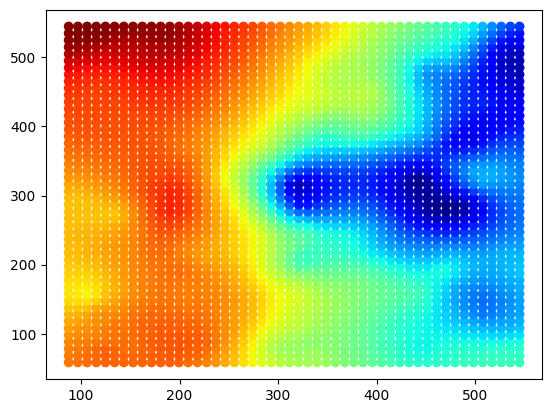

In [27]:
plt.scatter(x_grid,y_grid,c=vs_inter[:,:,33],cmap='jet')